# HW4, Problem 2

### Part a) and b)
* Reformulate into quadratic objective function and linear constraints. 
* Find reasonable constant C (not too small/too large) that gives low misclassification rate.

Cross validation for constant C:

objective value = 1.2600632956601672
solution = [-0.773389638858241, 0.8667289984287927, 0.7133331191966268]
C, misclassification rate = 100, 0.225

objective value = 0.8578198884555457
solution = [-0.6493119021601678, 0.7123117552989581, 0.5919728471124861]
C, misclassification rate = 105, 0.23

objective value = 0.655251599287167
solution = [-0.6126277439398715, 0.6303950184177683, 0.5077929893580932]
C, misclassification rate = 110, 0.235

objective value = 0.5071026577348919
solution = [-0.5202933178705937, 0.5293876925073769, 0.4762891230719077]
C, misclassification rate = 115, 0.225

objective value = 0.4109830684672511
solution = [-0.45747369870582977, 0.4676268679215885, 0.4385295666943066]
C, misclassification rate = 120, 0.225

objective value = 0.34110364153887945
solution = [-0.3754253272288656, 0.424673733310897, 0.4009437139732516]
C, misclassification rate = 125, 0.22

objective value = 0.2841519695499306
solution = [-0.34852888822160555

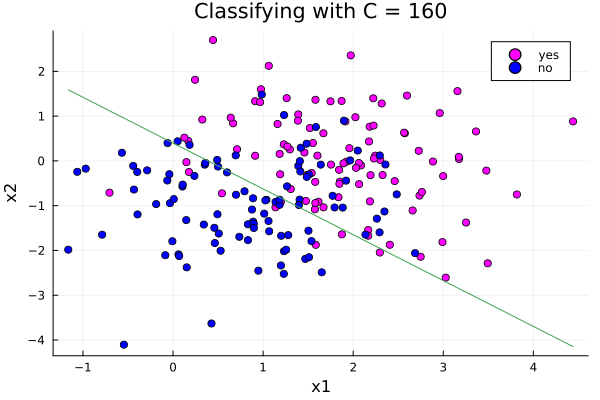

In [1]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

function svm1(A, y; C=100)  # separable data, but nonlinear constraint
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, M >= 0)       # the margin
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables

    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= 1-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)

    @NLobjective(model, Min, sum(β[i]^2 for i in 2:n))

    # optimize!(model)
    redirect_stdout((()->optimize!(model)),open("/dev/null", "w"))
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

# two-class data
df = CSV.read("two-class-data.csv", DataFrame)

fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

Cmin = 0
βmin = zeros(3)
rateMin = 1
design_matrix = hcat(ones(nrow(df)), df.x1, df.x2)
println("Cross validation for constant C:\n")
for c in range(100, 200, step=5)
    β = svm1(A, y; C=c)         # obtain the model parameters
    classifiers = sign.(design_matrix * β)
    misclassification_rate = sum(abs.((classifiers - df.y)/2)) / nrow(df)
    if misclassification_rate < rateMin
        rateMin = misclassification_rate
        βmin = β
        Cmin = c
    end
    println("C, misclassification rate = ", c, ", ", misclassification_rate, "\n")
end

println("Reasonable C that gives low misclassification rate:
C = ", Cmin, ", misclassification rate = ", rateMin, "\n")
println(βmin)

f(x) = (-βmin[1] - βmin[2]*x)/βmin[3] # decision boundary helper function

yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class

# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes")
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", 
    xlabel="x1", ylabel="x2", 
    title="Classifying with C = $Cmin")


### Part c)

When using a large value of C, we allow more violations--more observations to be on the wrong side of the margin--and therefore the margin is wider and more support vectors are involved in determining the hyperplane. The regression coefficients are determined from more data so the model has low variance and high bias, which means our model is less complex, more consistent among different datasets, but not super accurate on average.